# PII Detection - Experiments

## Final Report 
### Data Preparation
This section focuses on understanding the dataset, cleaning the text, identifying and removing outliers, and preparing the data to support the subsequent model evaluation.

### Model Evaluation
This section evaluates the performance of embedding-based multi-label classifiers using the following methods: (1) baseline comparison (training classifiers on each embedding type), (2) per-label performance analysis, (3) threshold tuning, and (4) cross-validation.

#### Baseline Performance

Across four embedding methods and five classical classifiers, the best configuration was:

**Word2Vec + Linear SVM (One-vs-Rest)**

- Macro F1: 0.9586  
- Micro F1: 0.9586  
- Runtime: 0.504s

This model was selected as the baseline due to its combination of high predictive accuracy and fast inference time.

#### Per-label Metrics

The following labels were used:  
`pii_list = ['NAME_STUDENT', 'PHONE_NUM', 'EMAIL', 'URL_PERSONAL', 'ID_NUM', 'USERNAME', 'STREET_ADDRESS']`

Per-label evaluation shows that all seven labels achieved high precision (0.88–0.94) and perfect recall (1.000). This result indicates that the model successfully captured all positive cases for each label. The perfect recall is largely due to the dataset containing mostly positive examples and relatively few negative ones.

#### Threshold Tuning

Thresholds were evaluated from 0.10 to 0.85. Performance peaked at a threshold of 0.65, achieving:  
- Macro F1: 0.9588  
- Micro F1: 0.9589

#### Cross-Validation

To ensure the results were not dependent on a single train/test split, 5-fold cross-validation was performed using the best model.

Cross-validation results (mean ± standard deviation):  
- CV Macro F1: mean = 0.9615, std = 0.0018  
- CV Micro F1: mean = 0.9616, std = 0.0018

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %pip install transformers[torch]

In [65]:
import sys, os
import json
sys.path.append(os.path.abspath(".."))
import importlib  
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import STOPWORDS
from wordcloud import WordCloud
import re
import time
import torch
import evaluate
import ast
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from collections import Counter 
nltk.download("stopwords")
nltk.download("punkt")

from gensim.models import Word2Vec 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.ensemble.GradientBoosting import GradientBoostingClassifier 
from xgboost import XGBClassifier
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier



from src.pii_utils import (
    load_dataset,
    stratified_split,
    get_embeddings, 
    train_and_eval
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df = load_dataset("../data/pii_data.csv")
df.head()


,Text,PII_types,has_PII,clean_text,clean_text_light
0,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'...",1,todays modern world technology become integral...,"in today's modern world, where technology has ..."
1,"In today's modern world, where technology has ...","{'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison...",1,todays modern world technology become integral...,"in today's modern world, where technology has ..."
2,Janice: A Student with a Unique Identity\n\nIn...,"{'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5...",1,janice student unique identity todays fastpace...,janice: a student with a unique identity\n\nin...
3,Christian is a student who goes by the usernam...,"{'NAME_STUDENT': ['Christian'], 'EMAIL': [], '...",1,christian student goes username stephensdennis...,christian is a student who goes by the usernam...
4,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T...",1,todays modern world technology become integral...,"in today's modern world, where technology has ..."


In [6]:
df["PII_types"].head()

0    {'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'...
1    {'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison...
2    {'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5...
3    {'NAME_STUDENT': ['Christian'], 'EMAIL': [], '...
4    {'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T...
Name: PII_types, dtype: object

## Stratified split 

In [7]:
X_train, X_test, y_train, y_test = stratified_split(
    df, 
    text_col ="clean_text",
    label_col="has_PII"
)
print(f"Total size: {len(df)}")
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}"   )

Total size: 2000
Train size: 1600, Test size: 400


## 2 Data & Model Visualization
### 2.1. Basic EDA
Understand dataset with label balance & text length

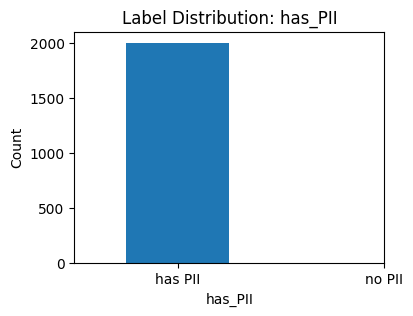

In [8]:
# Label distribution
plt.figure(figsize=(4, 3))
df["has_PII"].value_counts().plot(kind="bar")
plt.xticks([0, 1], ["has PII", "no PII"], rotation=0)
plt.title("Label Distribution: has_PII")
plt.ylabel("Count")
plt.show()


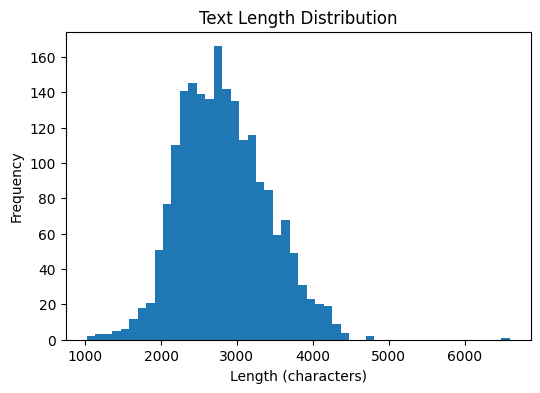

In [9]:
# Text length distribution
df["Text_len"] = df["Text"].astype(str).str.len()

plt.figure(figsize=(6, 4))
plt.hist(df["Text_len"] , bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.show()


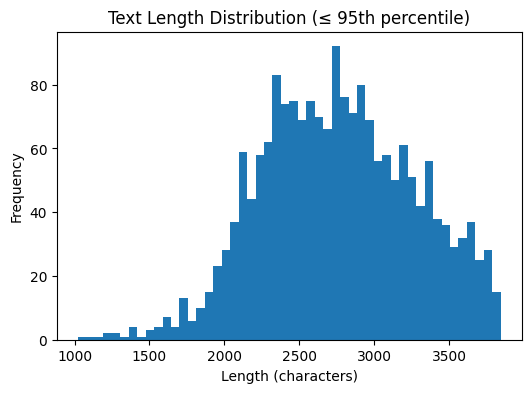

In [10]:
# Zoomed-in view (e.g., up to 95th percentile)
import numpy as np
p95 = np.percentile(df["Text_len"], 95)
plt.figure(figsize=(6, 4))
plt.hist(df[df["Text_len"] <= p95]["Text_len"], bins=50)
plt.title("Text Length Distribution (≤ 95th percentile)")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.show()


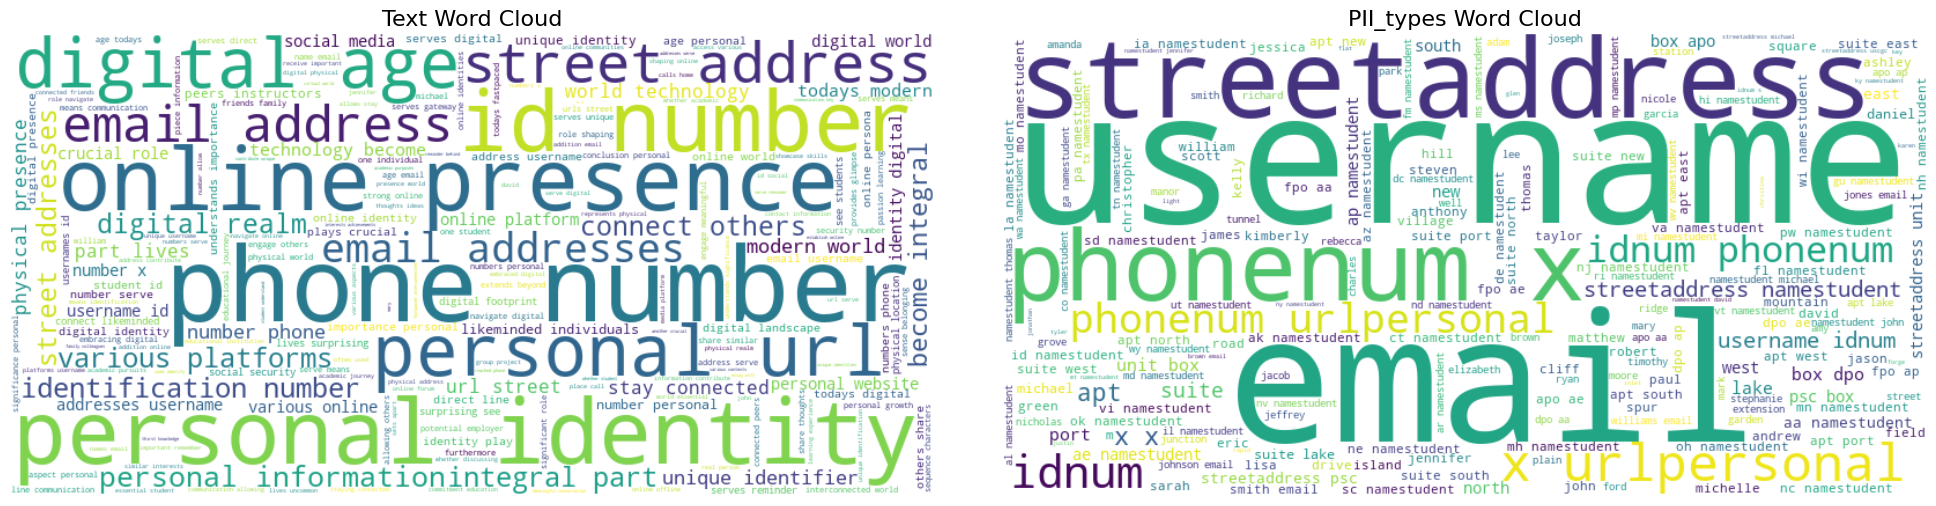

In [11]:
text_columns = {
    "Text": df['Text'],
    "PII_types": df['PII_types'],
}

fig, axes = plt.subplots(1, len(text_columns), figsize=(10 * len(text_columns), 5))

if len(text_columns) == 1:
    axes = [axes]

for i, (name, column) in enumerate(text_columns.items()):
    text = ' '.join(column.astype(str).tolist()) # Combine all text
    text = re.sub(r'[^A-Za-z\s]', '', text)     # Clean text: remove non-alphabetic characters
    text = text.lower() # Convert to lowercase
    stopwords = set(STOPWORDS)     # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)     # Generate word cloud
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"{name} Word Cloud", fontsize=16)

plt.tight_layout()
plt.show()

Using the word clouds shows both the text content and the PII labels strongly emphasize key personal identifiers such as name, email, phone numbers, street address, and ID numbers. This confirms that the database heavily centers around personal informations.

### 2.2. Text Length with numeric features

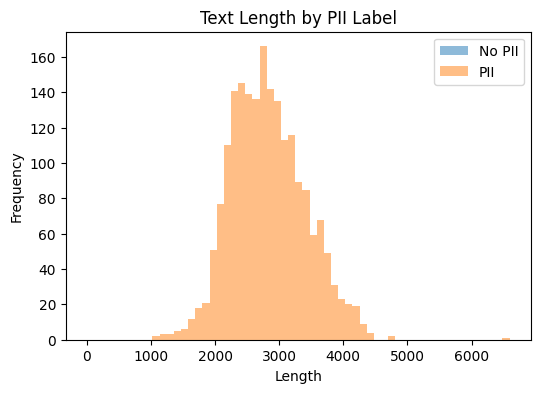

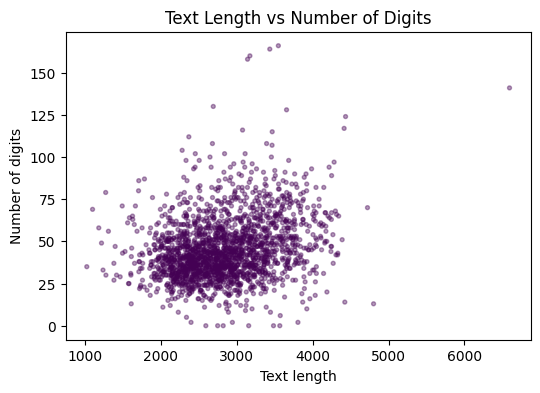

In [12]:
# Example simple numeric features
df["num_digits"] = df["Text"].astype(str).str.count(r"\d")
df["num_at"] = df["Text"].astype(str).str.count("@")

# Compare PII vs non-PII for text length
plt.figure(figsize=(6, 4))
for label, name in [(0, "No PII"), (1, "PII")]:
    subset = df[df["has_PII"] == label]
    plt.hist(subset["Text_len"], bins=50, alpha=0.5, label=name)

plt.legend()
plt.title("Text Length by PII Label")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

# 2D scatter: length vs digits
plt.figure(figsize=(6, 4))
plt.scatter(df["Text_len"], df["num_digits"], c=df["has_PII"], alpha=0.4, s=8)
plt.title("Text Length vs Number of Digits")
plt.xlabel("Text length")
plt.ylabel("Number of digits")
plt.show()


With this database, we just only train with feature has_PII, there are certain no features of none has_PII. It helps the model learn what PII looks like, but not what non_PII looks like. Therefore, the risks could happen that the model might think everything is PII because it never learned what normal text, causing lower accuracy. 

## 3. Embeddings
### TF-IDF
TF-IDF converts text into numerical features by measuring: TF (Term Frequency) how often a word appears in a document, IDF (Inverse Document Frequency)how rare the word is across all documents

It highlights important words and downweights common ones, produces sparse, high-dimensional vectors. 

In [28]:
# Choose embedding method
X_train_tfidf, X_test_tfidf = get_embeddings(
    method="tfidf",
    X_train=X_train,
    X_test=X_test,
    max_features=5000       
)

X_train_tfidf.shape, X_test_tfidf.shape


((1600, 5000), (400, 5000))

### Word2Vec
Word2Vec is a neural network model that learns word meanings by looking at how words appear near each other in sentences.

For example:
“email”, “gmail”, “hotmail” -> their vectors will be close together.

Captures semantic relationships (e.g., king – man + woman ≈ queen).

In [14]:
X_train_w2v, X_test_w2v = get_embeddings(
    method="word2vec",
    X_train=X_train,
    X_test=X_test
)

X_train_w2v.shape, X_test_w2v.shape



((1600, 100), (400, 100))

### BERT
BERT is a deep transformer model that learns contextual embeddings.
Each word’s meaning depends on the entire sentence around it.

Captures grammar, sentence structure, and deep semantic meaning.

Produces dynamic embeddings (the same word can have different vectors depending on context).

In [15]:
X_train_light, X_test_light, y_train, y_test = stratified_split(
    df,
    text_col="clean_text_light",
    label_col="has_PII"
)

X_train_bert, X_test_bert = get_embeddings(
    method="bert",
    X_train=X_train_light,
    X_test=X_test_light
)

X_train_bert.shape, X_test_bert.shape
# -> (num_train_samples, 384) for all-MiniLM-L6-v2


((1600, 384), (400, 384))

### GloVe 
GloVe primary objective is to capture semantic relationships between words by analyzing their co-occurrence patterns in a large text corpus. 

For example:

“coffee” often appears near “cup”, “mug”, “drink” → high co-occurrence.

“coffee” rarely appears near “car”, “engine” → low co-occurrence.

GloVe factorizes this co-occurrence matrix to find vectors that best reconstruct these probabilities.

In [16]:
X_train_glove, X_test_glove = get_embeddings(
    method="glove",
    X_train=X_train,
    X_test=X_test
)

X_train_glove.shape, X_test_glove.shape
# -> (num_train_samples, 100)

((1600, 100), (400, 100))

### 3.1. PCA visualization of embeddings
Principal Component Analysis (PCA) is a widely used dimensionality reduction technique that projects high-dimensional data onto a lower-dimensional space while maximally preserving variance. 

In this project, PCA is applied to visualize the structure of different text embeddings in 2D space. Since the original embeddings are high-dimensional (TF-IDF: up to ~5,000 dimensions after vocabulary selection; Word2Vec and GloVe: 100 dimensions;  BERT embedding: 384 dimensions), direct visualization is not possible. 

By reducing the embeddings to their first two principal components (PC1 and PC2), we can observe the global organization of the data points and the relevance of the dominant variance directions to subsequent task performance.

First, I trained each embedding methods using get_embeddings function.

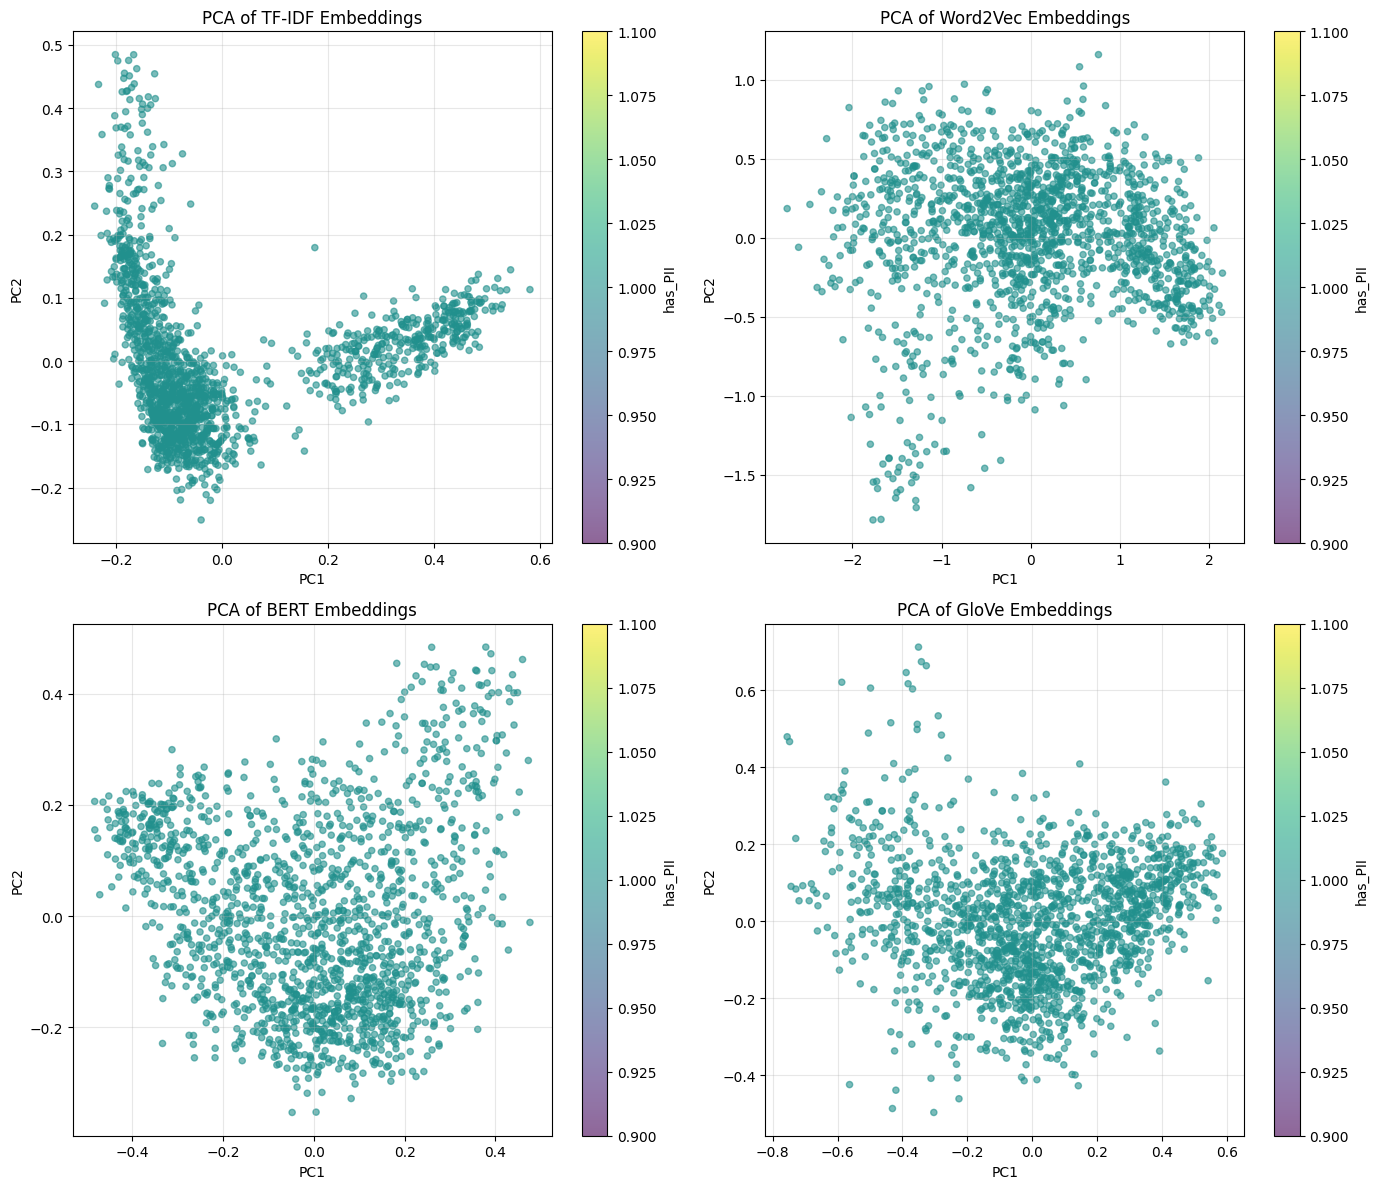

In [17]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

embeddings = {
    "TF-IDF": (X_train_tfidf, X_test_tfidf), 
    "Word2Vec": (X_train_w2v, X_test_w2v),
    "BERT": (X_train_bert, X_test_bert),
    "GloVe": (X_train_glove, X_test_glove)
}

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten to easily iterate

for idx_plot, (method, (X_train_emb, X_test_emb)) in enumerate(embeddings.items()):
    # Sample data
    idx = np.random.choice(len(X_train_emb), size=min(2000, len(X_train_emb)), replace=False)
    X_vis = X_train_emb[idx]
    y_vis = y_train.iloc[idx]

    # Apply PCA
    pca = PCA(n_components=2, random_state=42)
    X_vis_2d = pca.fit_transform(X_vis)

    # Plot on the corresponding subplot
    scatter = axes[idx_plot].scatter(
        X_vis_2d[:, 0], 
        X_vis_2d[:, 1], 
        c=y_vis, 
        alpha=0.6, 
        s=20,
        cmap='viridis'
    )
    axes[idx_plot].set_title(f"PCA of {method} Embeddings")
    axes[idx_plot].set_xlabel("PC1")
    axes[idx_plot].set_ylabel("PC2")
    axes[idx_plot].grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=axes[idx_plot], label='has_PII')

plt.tight_layout()
plt.show()

After viewing 4 PCA, we can conclude:

Currently, almost we get good points (dark green) and no bad points (yellow)

The old but simple TF-IDF and the new but good BERT both make the data very neatly arranged: good on one side, bad on the other -> only need a simple model (straight line) to get good results.

While Word2Vec and GloVe arrange the data in a chaotic way, good and bad are mixed everywhere -> to get good results, you we to use a much more complex model.

## 4. Feature Engineering (Representation Focus)

### Compare distributions before/after cleaning

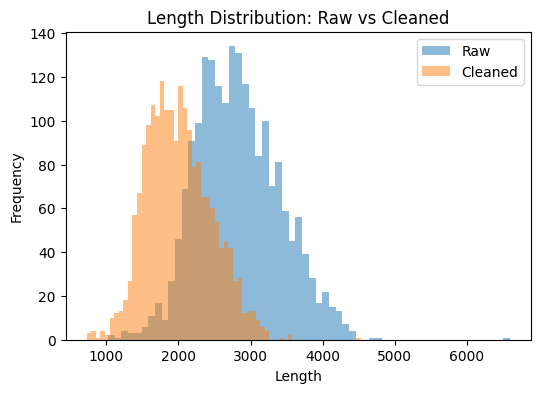

In [18]:
# original vs cleaned length
df["len_raw"] = df["Text"].astype(str).str.len()
df["len_clean"] = df["clean_text"].astype(str).str.len()

plt.figure(figsize=(6, 4))
plt.hist(df["len_raw"], bins=60, alpha=0.5, label="Raw")
plt.hist(df["len_clean"], bins=60, alpha=0.5, label="Cleaned")
plt.legend()
plt.title("Length Distribution: Raw vs Cleaned")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [19]:
stats = pd.DataFrame({
    "Metric": ["Mean", "Median", "Max", "Min", "95th Percentile", "99th Percentile"],
    "Raw" : [
        df['len_raw'].mean(),
        df['len_raw'].median(),
        df['len_raw'].max(),
        df['len_raw'].min(),
        df['len_raw'].quantile(0.95),
        df['len_raw'].quantile(0.99)
    ],
    "Cleaned"         : [
        df['len_clean'].mean(),
        df['len_clean'].median(),
        df['len_clean'].max(),
        df['len_clean'].min(),
        df['len_clean'].quantile(0.95),
        df['len_clean'].quantile(0.99)
    ]
})
stats["Raw"] = stats["Raw"].round(0).astype(int)
stats["Cleaned"] = stats["Cleaned"].round(0).astype(int)
print(stats.to_string(index=False))

         Metric  Raw  Cleaned
           Mean 2828     2006
         Median 2784     1968
            Max 6595     4531
            Min 1023      727
95th Percentile 3845     2792
99th Percentile 4242     3089


After cleaning, we successfully removed extreme outliers and reduced the maximum length by ~42%, making the dataset much more suitable for model training.

## 5. Embeddings Evaluation
### 5.1. Redefining the Target Variable

Initially, the label has_PII was a binary flag (0/1) indicating only the presence or absence of any PII. While simple, this representation provides very limited supervision signal for training models to detect specific types of PII.

Instead, we define a more informative multi-label target based on **PII types**. Using type-level annotations offers two major advantages:
- The model learns to recognize patterns specific to each PII category (e.g., phone number format vs email structure).
- Evaluation becomes more fine-grained and actionable.

First, we need to turn the PII string into real dictionary .

In [20]:

type(df['PII_types'].iloc[0])
df['PII_types'] = df['PII_types'].apply(lambda x: json.loads(x.replace("'", '"')))


In [21]:
df['PII_types'].value_counts()

PII_types
{'NAME_STUDENT': ['Jordan'], 'EMAIL': ['roberto35@gmail.com'], 'USERNAME': ['john75'], 'ID_NUM': ['QFKS39116285013003'], 'PHONE_NUM': ['(933)631-9373'], 'URL_PERSONAL': ['https://linkedin.com/in/laurensullivan', 'https://github.com/michael13', 'https://facebook.com/scabrera'], 'STREET_ADDRESS': ['20939 Buck Gateway, Port Oliviaside, KY 48411', '03325 Eric Underpass Suite 388, Jenniferfurt, MH 38935']}    1
{'NAME_STUDENT': ['Sandra Keller'], 'EMAIL': ['zadams@gmail.com'], 'USERNAME': ['cathy42', 'johnsonjustin'], 'ID_NUM': ['228979061'], 'PHONE_NUM': ['001-388-541-0582'], 'URL_PERSONAL': ['https://github.com/allison15', 'https://facebook.com/justin12'], 'STREET_ADDRESS': ['34637 Paul Gardens, Samuelstad, NH 07805']}                                                                                             1
{'NAME_STUDENT': ['Martin'], 'EMAIL': ['stacygoodwin@hotmail.com'], 'USERNAME': ['davilakaren'], 'ID_NUM': ['583-MPF'], 'PHONE_NUM': ['001-764-790-4323x06557'], 'URL_PERS

In [22]:

PII_counts = Counter([pii_type for pii_dict in df['PII_types'] for pii_type, items in pii_dict.items() if items for _ in items])
pd.DataFrame.from_dict(PII_counts, orient='index', columns=['Count']).sort_values(by='Count', ascending=False)

,Count
NAME_STUDENT,2486
PHONE_NUM,2480
EMAIL,2459
URL_PERSONAL,2454
ID_NUM,2440
USERNAME,2438
STREET_ADDRESS,2378


**Key observations**:

Only these **7 PII categories** appear in the dataset.

This balanced, 7-class multi-label setup is ideal for training and fair evaluation of embedding methods.

We proceed with a **7-class multi-label classification task** using exactly these categories.

### 4.2. Evaluation of Embeddings for PII Types 
I redefined train and test slipt 


In [23]:
pii_list = ['NAME_STUDENT','PHONE_NUM','EMAIL','URL_PERSONAL','ID_NUM','USERNAME','STREET_ADDRESS']

for pii in pii_list:
    df[pii] = df['PII_types'].apply(lambda x: 1 if pii in x and x[pii] else 0)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(f"Total  : {len(df)}")
print(f"Train  : {len(train_df)}")
print(f"Test   : {len(test_df)}")

Total  : 2000
Train  : 1600
Test   : 400


In [24]:
X_train_text = train_df['clean_text']
X_test_text  = test_df['clean_text']
y_train = train_df[pii_list].values
y_test  = test_df[pii_list].values

# Get each embeddings
X_train_tfidf, X_test_tfidf = get_embeddings("tfidf", X_train_text, X_test_text)
X_train_w2v,   X_test_w2v   = get_embeddings("word2vec", X_train_text, X_test_text)
X_train_bert,  X_test_bert  = get_embeddings("bert", X_train_text, X_test_text)
X_train_glove, X_test_glove = get_embeddings("glove", X_train_text, X_test_text)

**Using One-vs-Rest**

I used One-vs-Rest strategy for OneVsRestClassifier(LogisticRegression()) instead of LogisticRegression() because LogisticRegression() by default is for single-label classification (one column). But in this case y_train has 7 columns. Therefore, it's better to use OneVsRestClassifier - the standard way for multi-label.

**Macro F1**

Definition: Average F1-score across all labels/classes, giving equal weight to each label.

Use Macro F1 when:
- Need to measure overall performance across all labels, treating rare and common labels equally.
- The dataset is imbalanced.
- Each class is equally important, even if some appear very rarely.

**Micro F1**
Definition: Computes global precision and recall by counting total TP, FP, FN across all labels.

Use Micro F1 when:
- Need to measure overall accuracy considering all predictions together.
- Classes are imbalanced, but you want performance dominated by frequent labels.
- A metric similar to multi-label accuracy, but more robust.

In [ ]:
embeddings = {
    "TF-IDF": (X_train_tfidf, X_test_tfidf), 
    "Word2Vec": (X_train_w2v, X_test_w2v),
    "BERT": (X_train_bert, X_test_bert),
    "GloVe": (X_train_glove, X_test_glove)
}

results = []

print("Training and testing 4 embeddings")
for name, (X_tr, X_te) in embeddings.items():
    print(f"\n=== Embedding: {name} ===")

    start = time.time()
    model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    model.fit(X_tr, y_train)
    train_time = time.time() - start
    
    start = time.time()
    y_pred = model.predict(X_te)
    pred_time = time.time() - start

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')  

    print(f"   Macro F1  = {macro_f1:.4f}")
    print(f"   Micro F1  = {micro_f1:.4f}")
    print(f"   Train time: {train_time:.2f}s | Predict time: {pred_time:.3f}s")
    
    results.append({
        "Embedding": name,
        "Macro F1": round(macro_f1, 4),
        "Micro F1": round(micro_f1, 4),
        "Train+Predict Time (s)": round(train_time + pred_time, 2)
    })
results_df = pd.DataFrame(results).sort_values(by="Macro F1", ascending=False)
print(f"\n{results_df.to_string(index=False)}")

    

Training and testing 4 embeddings

=== Embedding: TF-IDF ===
   Macro F1  = 0.9577
   Micro F1  = 0.9578
   Train time: 1.47s | Predict time: 0.081s

=== Embedding: Word2Vec ===
   Macro F1  = 0.9576
   Micro F1  = 0.9577
   Train time: 0.27s | Predict time: 0.007s

=== Embedding: BERT ===
   Macro F1  = 0.9577
   Micro F1  = 0.9578
   Train time: 0.36s | Predict time: 0.017s

=== Embedding: GloVe ===
   Macro F1  = 0.9577
   Micro F1  = 0.9578
   Train time: 0.27s | Predict time: 0.005s

Embedding  Macro F1  Micro F1  Train+Predict Time (s)
   TF-IDF    0.9577    0.9578                    1.55
     BERT    0.9577    0.9578                    0.38
    GloVe    0.9577    0.9578                    0.27
 Word2Vec    0.9576    0.9577                    0.28



**Final conclusion**:  

Across four embedding methods - TF-IDF, Word2Vec, GloVe, BERT; the performance is almost similar with macro F1 and micro F1 scores arround 0.957-0.958. This can figure out the classifier (One-vs-Rest Logistic Regression) plays the most final performance, while embedding choice influence efficiency rather than accuracy. 

In the terms of speed, TF-IDF is the slowest overall (1.55s) due to high-dimensional sparse vectors. Word2Vec and GloVe shows the fastest training and prediction times (~0.27–0.28s) because they produce compact, dense embeddings. BERT provides contextual representations and remains relatively efficient (0.38s), though slower than classical embeddings.

Overall, TF-IDF good at capturing specific words (e.g., structured tokens like emails or numeric sequences), Word2Vec and GloVe capture semantic similarity across words, while transformer-based BERT capture contextual meaning, making it more robust for tasks involving ambiguity or polysemy.

## 5. Modeling & Hyperparameter Tuning
### 5.1. Baseline models on one embedding (e.g., TF-IDF)
### Classifier Models Overview

| Model                              | Full Name & Type                              | Description                                                                                   | Strengths                                                                                 | Weaknesses / Notes                                                        |
|------------------------------------|------------------------------------------------|------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **Logistic Regression (OvR)**      | Logistic Regression + One-vs-Rest              | Linear probabilistic classifier; trains one binary classifier per label using OvR strategy.   | Very fast, interpretable coefficients, strong baseline, scales well                      | Assumes linear separability; weaker on complex non-linear patterns        |
| **Linear SVM (OvR)**               | Linear Support Vector Machine + One-vs-Rest    | Finds maximum-margin hyperplanes for each label separately (OvR).                            | Excellent margin maximization, robust in high-dimensional space (e.g. TF-IDF text)        | Slower training than Logistic Regression; sensitive to feature scaling    |
| **Random Forest**                  | Random Forest Classifier                       | Ensemble of decision trees using bagging and random feature selection; natively multi-label.  | Highly robust, handles non-linearity, low overfitting risk, built-in feature importance | Larger model size, slower inference than linear models                    |
| **XGBoost (OvR)**                  | Extreme Gradient Boosting + One-vs-Rest        | State-of-the-art gradient-boosted decision trees; wrapped in OvR for multi-label tasks.       | Usually highest accuracy, fast with regularization, handles sparse data very well        | Needs more hyperparameter tuning than Random Forest                        |
| **Naive Bayes (MultiOutput)**      | Gaussian Naive Bayes + MultiOutputClassifier   | Probabilistic classifier based on Bayes’ theorem with independence assumption between features. | Extremely fast training & prediction, surprisingly effective on text data               | Strong independence assumption rarely holds in reality                     |

**Summary of wrappers used:**
- `OneVsRestClassifier`: For algorithms that don’t natively support multi-label → trains one classifier per label.
- `MultiOutputClassifier`: Alternative strategy for multi-label problems (used here for Naive Bayes).
- Random Forest needs no wrapper → supports multi-label classification directly.

In [ ]:
# Define classifiers models for multi-label
clf_dict = {
    "Logistic Regression (OvR)": OneVsRestClassifier(
        LogisticRegression(max_iter=1000)
    ),

    "Linear SVM (OvR)": OneVsRestClassifier(
        LinearSVC(max_iter=5000)
    ),

    # RandomForest natively supports multi-output if y is 2D
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    ),

    "XGBoost (OvR)": OneVsRestClassifier(
        XGBClassifier(
            n_estimators=200,
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        )
    ),

    # GaussianNB is NOT multi-label by default, therefore wrap MultiOutputClassifier
    "Naive Bayes (MultiOutput)": MultiOutputClassifier(
        GaussianNB()
    )
}

# 2) GaussianNB requires dense arrays. Some embeddings might be sparse (TF-IDF).
def to_dense_if_needed(X, clf_name):
    if hasattr(X, "toarray") and ("Naive Bayes" in clf_name):
        return X.toarray()
    return X

all_results = []
print("Running experiments...\n")

for emb_name, (X_tr, X_te) in embeddings.items():
    for clf_name, clf in clf_dict.items():

        # Make input compatible when needed
        X_tr_use = to_dense_if_needed(X_tr, clf_name)
        X_te_use = to_dense_if_needed(X_te, clf_name)

        start = time.time()

        clf.fit(X_tr_use, y_train)
        y_pred = clf.predict(X_te_use)

        total_time = time.time() - start

        macro = f1_score(y_test, y_pred, average="macro")
        micro = f1_score(y_test, y_pred, average="micro")

        all_results.append({
            "Embedding": emb_name,
            "Classifier": clf_name,
            "Macro F1": round(macro, 4),
            "Micro F1": round(micro, 4),
            "Time (s)": round(total_time, 3)
        })

final_df = pd.DataFrame(all_results)

# sort primarily by Macro F1, then Micro F1, then time
final_df = final_df.sort_values(
    by=["Macro F1", "Micro F1", "Time (s)"],
    ascending=[False, False, True]
)

print(final_df.to_string(index=False))


Running experiments...

Embedding                Classifier  Macro F1  Micro F1  Time (s)
 Word2Vec          Linear SVM (OvR)    0.9586    0.9586     0.205
    GloVe             XGBoost (OvR)    0.9584    0.9585     4.133
    GloVe             Random Forest    0.9584    0.9584     1.857
    GloVe          Linear SVM (OvR)    0.9582    0.9583     0.139
 Word2Vec             Random Forest    0.9581    0.9582     1.560
     BERT             XGBoost (OvR)    0.9581    0.9582    15.383
 Word2Vec             XGBoost (OvR)    0.9578    0.9579     4.206
    GloVe Logistic Regression (OvR)    0.9577    0.9578     0.146
     BERT Logistic Regression (OvR)    0.9577    0.9578     0.209
   TF-IDF Logistic Regression (OvR)    0.9577    0.9578     1.067
     BERT             Random Forest    0.9577    0.9578     4.367
     BERT          Linear SVM (OvR)    0.9577    0.9577     0.701
 Word2Vec Logistic Regression (OvR)    0.9576    0.9577     0.121
   TF-IDF             Random Forest    0.9575    0.9

Save model and features (train/test) of each embeddings. 

In [27]:
import joblib
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X_tfidf = tfidf_vectorizer.fit_transform(df['Text'])

tokenized_train = [doc.split() for doc in X_train]
tokenized_test = [doc.split() for doc in X_test]

# Train Word2Vec on the tokenized training data
w2v_model = Word2Vec(
    sentences=tokenized_train, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4
)
        

joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
w2v_model.save('models/word2vec.model')
np.save("features/X_train_tfidf.npy", X_train_tfidf)
np.save("features/X_test_tfidf.npy", X_test_tfidf)
np.save("features/X_train_bert.npy", X_train_bert)
np.save("features/X_test_bert.npy", X_test_bert)
np.save("features/X_train_w2v.npy", X_train_w2v)
np.save("features/X_test_w2v.npy", X_test_w2v)



### 5.2. Best baseline
Ensure y are numpy arrays

In [42]:
Y_tr = y_train.values if hasattr(y_train, "values") else y_train
Y_te = y_test.values  if hasattr(y_test, "values")  else y_test

label_names = [f"Label_{i}" for i in range(Y_tr.shape[1])]
n_labels = Y_tr.shape[1]


Following to the result of baseline models on one embeddings, I chose Word2Vec + Linear SVM that gives high both Marco and Mirco F1 as well as low timing. 

In [44]:
best_embedding_name = "Word2Vec"
best_clf = OneVsRestClassifier(LinearSVC(max_iter=5000))

X_tr_best, X_te_best = embeddings[best_embedding_name]
best_clf.fit(X_tr_best, Y_tr)
Y_pred_best = best_clf.predict(X_te_best)

macro_best = f1_score(Y_te, Y_pred_best, average="macro")
micro_best = f1_score(Y_te, Y_pred_best, average="micro")

print("Best baseline:", best_embedding_name, "+ Linear SVM (OvR)")
print("Macro F1:", round(macro_best,4), "| Micro F1:", round(micro_best,4))


Best baseline: Word2Vec + Linear SVM (OvR)
Macro F1: 0.9586 | Micro F1: 0.9586


In [43]:
per_label_rows = []
for i, lab in enumerate(label_names):
    p = precision_score(Y_te[:, i], Y_pred_best[:, i], zero_division=0)
    r = recall_score(Y_te[:, i], Y_pred_best[:, i], zero_division=0)
    f1 = f1_score(Y_te[:, i], Y_pred_best[:, i], zero_division=0)
    per_label_rows.append([lab, p, r, f1])

per_label_df = pd.DataFrame(per_label_rows, columns=["Label", "Precision", "Recall", "F1"])
per_label_df = per_label_df.sort_values("F1", ascending=False)

print(per_label_df.to_string(index=False))
print(label_names)


  Label  Precision  Recall       F1
Label_0   0.947500 1.00000 0.973042
Label_4   0.936387 0.99729 0.965879
Label_3   0.932500 1.00000 0.965071
Label_1   0.917500 1.00000 0.956975
Label_2   0.912500 1.00000 0.954248
Label_6   0.912500 1.00000 0.954248
Label_5   0.887500 1.00000 0.940397
['Label_0', 'Label_1', 'Label_2', 'Label_3', 'Label_4', 'Label_5', 'Label_6']


The recall scores for all PII labels are 1.000 because the dataset contains strong and consistent PII patterns, enabling the classifier to detect all positive cases (FN=0) and making detection extremely easy. 

### 5.3. Thresholds 
Threshold is a value used to convert a model's predicted probabilities or scores into discrete class labels. 

Because currently multi-label models do not output 0/1 --> they output probabilities. So, to turn these into predictions, we mush pick a threshold. 

In [66]:
from sklearn.metrics import f1_score

prob_clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
prob_clf.fit(X_tr_best, Y_tr)
Y_prob = prob_clf.predict_proba(X_te_best)  # shape (n_samples, n_labels)

thresholds = np.arange(0.1, 0.9, 0.05)
tune_rows = []

for t in thresholds:
    Y_pred_t = (Y_prob >= t).astype(int)
    macro_t = f1_score(Y_te, Y_pred_t, average="macro")
    micro_t = f1_score(Y_te, Y_pred_t, average="micro")
    tune_rows.append([t, macro_t, micro_t])

tune_df = pd.DataFrame(tune_rows, columns=["Threshold", "Macro F1", "Micro F1"])
best_t = tune_df.sort_values("Macro F1", ascending=False).iloc[0]

print(tune_df.to_string(index=False))
print("\nBest threshold by Macro F1:", round(best_t["Threshold"], 4))


 Threshold  Macro F1  Micro F1
      0.10  0.957667  0.957752
      0.15  0.957667  0.957752
      0.20  0.957667  0.957752
      0.25  0.957667  0.957752
      0.30  0.957667  0.957752
      0.35  0.957667  0.957752
      0.40  0.957473  0.957558
      0.45  0.957263  0.957348
      0.50  0.957621  0.957704
      0.55  0.958518  0.958598
      0.60  0.958436  0.958520
      0.65  0.958888  0.958966
      0.70  0.956956  0.957094
      0.75  0.954850  0.955054
      0.80  0.951161  0.951449
      0.85  0.932300  0.932781

Best threshold by Macro F1: 0.65


By default, a threshold of 0.5 is often used, meaning predictions with probabilities above 0.5 are classified as positive, and those below are classified as negative. 

But in this cases, at 0.5 we gets macro F1 = 0.9576; at 0.65 we recieves 0.9588 (best threshold).

### 5.4. Cross-validation 
Cross-validation is a technique used to check how well a machine learning model performs on unseen data while preventing overfitting.




In [67]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

macro_scores, micro_scores = [], []

X_all = X_tr_best   # training features
Y_all = Y_tr

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(X_all.shape[0]))):
    X_fold_tr = X_all[train_idx]
    X_fold_va = X_all[val_idx]
    Y_fold_tr = Y_all[train_idx]
    Y_fold_va = Y_all[val_idx]

    clf_cv = OneVsRestClassifier(LinearSVC(max_iter=5000))
    clf_cv.fit(X_fold_tr, Y_fold_tr)
    Y_va_pred = clf_cv.predict(X_fold_va)

    macro_scores.append(f1_score(Y_fold_va, Y_va_pred, average="macro"))
    micro_scores.append(f1_score(Y_fold_va, Y_va_pred, average="micro"))

print("\nCV Macro F1: mean =", round(np.mean(macro_scores),4), "std =", round(np.std(macro_scores),4))
print("CV Micro F1: mean =", round(np.mean(micro_scores),4), "std =", round(np.std(micro_scores),4))



CV Macro F1: mean = 0.9615 std = 0.0018
CV Micro F1: mean = 0.9616 std = 0.0018
